# Exploring Combined PrimeKG and SemMed Normalized Data

This notebook provides interactive exploration and visualization of the combined normalized databases.


In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import os

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the data
def load_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load both original and combined datasets
primekg_data = load_data('../primekg_normalized/primekg_normalized_sample.json')
semmed_data = load_data('../normalized_semmed_sample.json')

print(f"PrimeKG entities: {len(primekg_data)}")
print(f"SemMed entities: {len(semmed_data)}")


Matplotlib is building the font cache; this may take a moment.


PrimeKG entities: 5
SemMed entities: 91


## 1. Basic Data Analysis


In [4]:
# Analyze entity types in each dataset
def analyze_types(data, name):
    type_counts = Counter()
    for entity in data.values():
        for entity_type in entity.get('type', []):
            type_counts[entity_type] += 1
    
    print(f"\n{name} Type Distribution:")
    for entity_type, count in type_counts.most_common(10):
        print(f"  {entity_type}: {count}")
    
    return type_counts

primekg_types = analyze_types(primekg_data, "PrimeKG")
semmed_types = analyze_types(semmed_data, "SemMed")



PrimeKG Type Distribution:
  biolink:Gene: 5
  biolink:GeneOrGeneProduct: 5
  biolink:GenomicEntity: 5
  biolink:ChemicalEntityOrGeneOrGeneProduct: 5
  biolink:PhysicalEssence: 5
  biolink:OntologyClass: 5
  biolink:BiologicalEntity: 5
  biolink:ThingWithTaxon: 5
  biolink:NamedThing: 5
  biolink:PhysicalEssenceOrOccurrent: 5

SemMed Type Distribution:
  biolink:NamedThing: 91
  biolink:BiologicalEntity: 10
  biolink:ThingWithTaxon: 10
  biolink:Protein: 6
  biolink:GeneProductMixin: 6
  biolink:Polypeptide: 6
  biolink:ChemicalEntityOrGeneOrGeneProduct: 6
  biolink:ChemicalEntityOrProteinOrPolypeptide: 6
  biolink:GeneOrGeneProduct: 6
  biolink:MacromolecularMachineMixin: 6


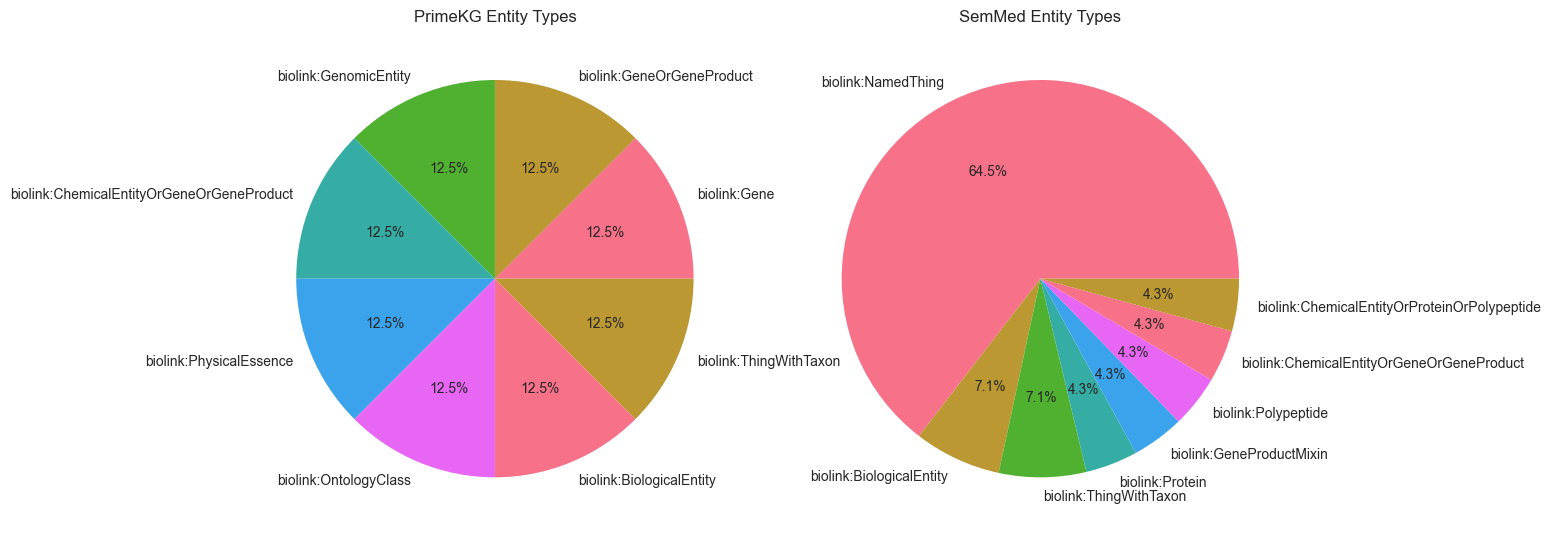

In [5]:
# Visualize type distribution comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PrimeKG types
primekg_top = dict(primekg_types.most_common(8))
ax1.pie(primekg_top.values(), labels=primekg_top.keys(), autopct='%1.1f%%')
ax1.set_title('PrimeKG Entity Types')

# SemMed types
semmed_top = dict(semmed_types.most_common(8))
ax2.pie(semmed_top.values(), labels=semmed_top.keys(), autopct='%1.1f%%')
ax2.set_title('SemMed Entity Types')

plt.tight_layout()
plt.show()


## 2. Simple Union Combination


In [6]:
# Simple union combination
def simple_union_merge(primekg_data, semmed_data):
    combined = {}
    
    # Add all PrimeKG entities
    for entity_id, entity_data in primekg_data.items():
        combined[entity_id] = entity_data.copy()
        combined[entity_id]['source_databases'] = ['PrimeKG']
    
    # Add SemMed entities
    for entity_id, entity_data in semmed_data.items():
        if entity_id in combined:
            # Merge existing entity
            existing = combined[entity_id]
            existing['source_databases'].append('SemMed')
            
            # Merge types
            existing_types = set(existing['type'])
            existing_types.update(entity_data['type'])
            existing['type'] = list(existing_types)
            
            # Merge equivalent identifiers
            existing_equiv = {eq['identifier'] for eq in existing['equivalent_identifiers']}
            for eq in entity_data['equivalent_identifiers']:
                if eq['identifier'] not in existing_equiv:
                    existing['equivalent_identifiers'].append(eq)
        else:
            # Add new entity
            new_entity = entity_data.copy()
            new_entity['source_databases'] = ['SemMed']
            combined[entity_id] = new_entity
    
    return combined

combined_data = simple_union_merge(primekg_data, semmed_data)
print(f"Combined dataset contains {len(combined_data)} entities")


Combined dataset contains 96 entities


In [7]:
# Analyze the combined dataset
def analyze_combined_data(data):
    stats = {
        'total_entities': len(data),
        'primekg_only': 0,
        'semmed_only': 0,
        'both_sources': 0,
        'type_distribution': Counter(),
        'source_distribution': Counter()
    }
    
    for entity in data.values():
        sources = entity.get('source_databases', [])
        
        if sources == ['PrimeKG']:
            stats['primekg_only'] += 1
        elif sources == ['SemMed']:
            stats['semmed_only'] += 1
        else:
            stats['both_sources'] += 1
        
        for source in sources:
            stats['source_distribution'][source] += 1
        
        for entity_type in entity.get('type', []):
            stats['type_distribution'][entity_type] += 1
    
    return stats

stats = analyze_combined_data(combined_data)
print(f"Total entities: {stats['total_entities']}")
print(f"PrimeKG only: {stats['primekg_only']}")
print(f"SemMed only: {stats['semmed_only']}")
print(f"Both sources: {stats['both_sources']}")


Total entities: 96
PrimeKG only: 5
SemMed only: 91
Both sources: 0


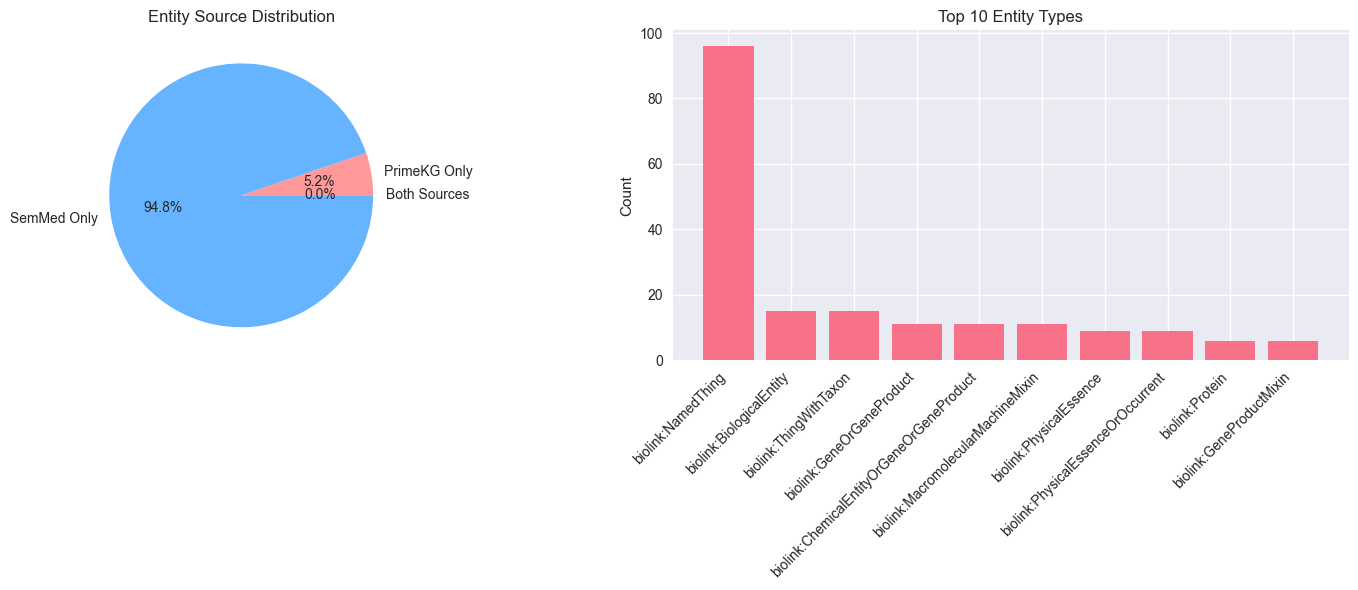

In [8]:
# Visualize source overlap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Source distribution pie chart
source_counts = [stats['primekg_only'], stats['semmed_only'], stats['both_sources']]
source_labels = ['PrimeKG Only', 'SemMed Only', 'Both Sources']
colors = ['#ff9999', '#66b3ff', '#99ff99']

ax1.pie(source_counts, labels=source_labels, colors=colors, autopct='%1.1f%%')
ax1.set_title('Entity Source Distribution')

# Type distribution bar chart
top_types = dict(stats['type_distribution'].most_common(10))
ax2.bar(range(len(top_types)), list(top_types.values()))
ax2.set_xticks(range(len(top_types)))
ax2.set_xticklabels(list(top_types.keys()), rotation=45, ha='right')
ax2.set_title('Top 10 Entity Types')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()
